In [11]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lcc-fasd:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F724551%2F1259264%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T144516Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D741e0826fbda4f60adc2c784b2b17ce6c402a9ad04bc567699eb9ee4e39aef773fe57404f3c35a41e1f0eafa7e1b59f812ccc1e1766a284fd78bc8712c518db5890bafe4b435beb696de2338f695f98829a28a119eae01717723bc51bdcab2caf28650fc29f6451fda28c0b23c447a60039fc85f26b8813e3cc48e845bdd9e92785af5a920e35ba14ece7cc8645936e280b7afb0410e2d4b20de6307878eca6b0f95f3573e3f70df98363014e57c4dc92ad41555c0a64e5160d80af81f5e98a156779d3fc913a170b0328f464b2dd3fc9f08b5d46ec999c0214d7bd6bd9fc20c51b13abfd56e2131bbe553af1a7980eff4df9405f932e800c2b537547e21788e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5196000412 bytes downloaded
Downloaded and uncompressed: lcc-fasd
Data source import complete.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

import numpy as np
import os
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.fft import fft2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import os
from PIL import Image


In [9]:
!cp  /content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation/real /content

mv: cannot stat '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation/real': No such file or directory


In [10]:
!cp  /content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation/spoof /content

mv: cannot stat '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation/spoof': No such file or directory


GET HISTOGRAM OF ALL IMAGE SIZE AND CALCULATE BEST SIZE

In [ ]:
def get_image_sizes(directories):
    sizes = []
    for directory in directories:
      for filename in os.listdir(directory):
          if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
              try:
                  with Image.open(os.path.join(directory, filename)) as img:
                      sizes.append(img.size)
              except Exception as e:
                  print(f"Failed to process {filename}: {e}")
    return sizes

def plot_image_sizes(sizes):
    size_counts = Counter(sizes)
    sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1])

    unique_sizes = [size for size, count in sorted_sizes]
    counts = [count for size, count in sorted_sizes]

    # Prepare data for plotting
    size_labels = [f"{w}x{h}" for w, h in unique_sizes]

    # Plot
    plt.figure(figsize=(30, 6))
    plt.bar(size_labels, counts, color='skyblue')
    plt.xlabel('Image Size (Width x Height)')
    plt.ylabel('Frequency')
    plt.title('Frequency of Each Image Size (Sorted by Count)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def weighted_mean_and_variance(sizes):
    size_counts = Counter(sizes)
    unique_sizes = list(size_counts.keys())
    counts = np.array(list(size_counts.values()))

    # Calculate weighted mean for width and height separately
    widths, heights = zip(*unique_sizes)

    mean_width = np.average(widths, weights=counts)
    mean_height = np.average(heights, weights=counts)

    # Calculate weighted variance for width and height separately
    var_width = np.average((np.array(widths) - mean_width) ** 2, weights=counts)
    var_height = np.average((np.array(heights) - mean_height) ** 2, weights=counts)

    return (mean_width, mean_height), (var_width, var_height)

def best_size_by_weighted_variance(sizes):
    (mean_width, mean_height), (var_width, var_height) = weighted_mean_and_variance(sizes)

    # Calculate total variance and select the size closest to the mean
    total_variance = var_width + var_height
    best_size = (int(mean_width), int(mean_height))  # Round to the nearest integer

    return best_size, total_variance

# Example usage
# source_directory = '/content/LCC_FASD_training/spoof'
# sizes = get_image_sizes([source_directory])
# plot_image_sizes(sizes)

# best_size, total_variance = best_size_by_weighted_variance(sizes)
# print(f"Best size based on weighted variance: {best_size}")
# print(f"Total weighted variance: {total_variance}")


def resize_image(image_path, target_size):
    # Open an image file
    with Image.open(image_path) as img:
        # Ensure the image is in RGB mode
        if img.mode != 'RGB':
            img = img.convert('RGB')
        # Resize image using bicubic interpolation
        img = img.resize(target_size, Image.BICUBIC)
        return img

def preprocess(source_dir, target_dir, target_size):
    # Create the target directory if it does not exist
    os.makedirs(target_dir, exist_ok=True)

    # Get a list of all files in the source directory
    for filename in os.listdir(source_dir):
        # Construct full file path
        file_path = os.path.join(source_dir, filename)

        # Check if the file is an image (you can add more extensions if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            try:
                # Resize the image
                resized_image = resize_image(file_path, target_size)
                # Save the resized image to the target directory
                resized_image.save(os.path.join(target_dir, filename))
                # print(f"Resized and saved: {filename}")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")
# Example usage
# source_directory = '/content/data'
# target_directory = '/content/pre_res'
# target_size = best_size  # Set your desired target size here
# preprocess(source_directory, target_directory, target_size)




# Define parameters for LBP
radius = 3
n_points = 8 * radius
METHOD = 'uniform'

def extract_lbp_features(image):
    gray_image = rgb2gray(image)
    lbp = local_binary_pattern(gray_image, n_points, radius, METHOD)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize the histogram
    return hist

def extract_frequency_features(image):
    gray_image = rgb2gray(image)
    f_transform = fft2(gray_image)
    f_transform_magnitude = np.abs(f_transform)
    f_transform_magnitude = f_transform_magnitude[:f_transform_magnitude.shape[0] // 2, :f_transform_magnitude.shape[1] // 2]
    return f_transform_magnitude.ravel()

def load_dataset(class1_dir, class2_dir):
    origin_size =0
    flag = True
    features = []
    labels = []
    for label, class_dir in enumerate([class1_dir, class2_dir]):
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            # print(file_path)
            image = imread(file_path)
            lbp_features = extract_lbp_features(image)
            freq_features = extract_frequency_features(image)
            combined_features = np.concatenate((lbp_features, freq_features))

            if flag ==True:
              origin_size = combined_features.shape
            current_shape = combined_features.shape
            if current_shape != origin_size:
              print(f"file_name:{file_path}\nimage shape:{image.shape}\norigin_size:{origin_size}\nlbp shape:{lbp_features.shape}\nfreq shape:{freq_features.shape}\ncombine shape:{combined_features.shape}\n\n\n")
              continue#if photo not in same size with another phot must ignore
            features.append(combined_features)
            # print(f"file_name:{file_path}\nimage shape:{image.shape}\norigin_size:{origin_size}\nlbp shape:{lbp_features.shape}\nfreq shape:{freq_features.shape}\ncombine shape:{combined_features.shape}\n\n\n")
            labels.append(label)
    return np.array(features), np.array(labels)

# prepare to train

In [128]:
# Directories containing images for two classes
class1_dir = '/content/LCC_FASD_training/real'
class2_dir = '/content/LCC_FASD_training/spoof'

#get best size of all data set
sizes = get_image_sizes([class1_dir,class2_dir])
# plot_image_sizes(sizes)
best_size, total_variance = best_size_by_weighted_variance(sizes)
# Load dataset
preprocess(class1_dir, "/content/LCC_FASD_training/real2", best_size)
preprocess(class2_dir, "/content/LCC_FASD_training/spoof2", best_size)

X, y = load_dataset("/content/LCC_FASD_training/real2", "/content/LCC_FASD_training/spoof2")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
# Initialize and train logistic regression model
model = LogisticRegression(max_iter=3000, verbose=1)
model.fit(X_train, y_train)

831
(831, 67107)
831
(831,)


LogisticRegression(max_iter=3000, verbose=1)

# extract accuracy

Accuracy: 79.04%
Precision: 79.86%
Recall: 79.04%
F1 Score: 79.42%


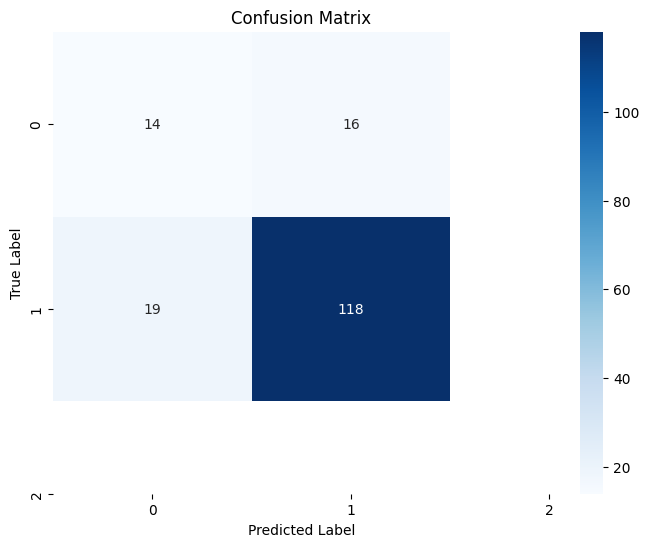

In [132]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# predict individually

In [155]:
# print(X_test.shape)
# print(X_test)
# Predict on test set
# image = imread("/content/LCC_FASD_training/real2/FT720P_id2_s0_105.png")
# image = imread("/content/LCC_FASD_training/spoof2/FT720P_G780_REDMI4X_id1_s1_175.png")
# image = imread("/content/LCC_FASD_training/spoof2/FT720P_G780_REDMI4X_id4_s0_30.png")
# image = imread("/content/LCC_FASD_training/real2/FT720P_id7_s0_30.png")
# image = imread("/content/3.jpg")
image = resize_image("/content/4.jpg" , best_size)
lbp_features = extract_lbp_features(image)
freq_features = extract_frequency_features(image)
combined_features = np.concatenate((lbp_features, freq_features))
# print(np.array(1,combined_features).shape)
y_pred = model.predict([combined_features])
print(y_pred)



[1]


In [36]:
import os
import random

def delete_random_files(directory_path, delete_ratio):
  """
  Deletes a random selection of files from a directory.

  Args:
      directory_path: Path to the directory containing files.
      delete_ratio: Ratio of files to delete (between 0 and 1).
  """
  files = os.listdir(directory_path)
  num_files_to_delete = int(len(files) * delete_ratio)
  random.shuffle(files)
  files_to_delete = files[:num_files_to_delete]

  for file in files_to_delete:
    os.remove(os.path.join(directory_path, file))

# Example usage (replace "your_directory" with the actual path)
delete_random_files("/content/LCC_FASD_training/real", 0.9)  # Delete 70% of files
delete_random_files("/content/LCC_FASD_training/spoof", 0.9)  # Delete 70% of files
